# Data Cleaning Tutorial

### This workbook illustrates how to explore and clean data with a geometry (point locations). 

First, import the libraries you'll need. Pandas, numpy, matplotlib and seaborn for visualizations are the basics. With geographic data, add folium and geopandas. For web, use flask, json, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Read in the data without any special calls first just to check it out. We'll likely restructure the input call once we've identified where the missing, inaccurate, and otherwise frustrating garbage data is.

In [2]:
df = pd.read_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives\Downloads\nchrp_data_2018.xlsx')

After importing, just open the data and check it out.

In [3]:
df.head()

,UniqueID,Origin,SiteID,Round,start_time,end_time,survey_date,observer,state,road_name,...,mw_richness,mw_richness_score,note_site,breeding_compscore,foraging_compscore,threats_compscore,weeds_compscore,mngt_compscore,total_score,Total Adjusted Score
0,{00836866-532E-44E2-B00C-69439194F86D},S123,{00836866-532E-44E2-B00C-69439194F86D},1,18:02:00,18:32:00,2018-08-21 05:00:00,"AGH, PKP",MN,792856,...,1.0,25,"Plants in mowed only: red clover (b), common r...",19.5,9.0625,9.500,6.3750,3.0,47.4375,55.159884
1,{00CEF306-9FBB-4341-A572-C1981C194C03},S123,{00CEF306-9FBB-4341-A572-C1981C194C03},1,14:06:00,14:37:00,2018-06-27 05:00:00,PKP,MN,416193,...,1.0,25,Took point from bridge. Huge solidago patch ne...,5.1,16.3125,14.375,6.5625,4.5,46.8500,54.476744
2,{0262F684-2BA5-4E44-B9C9-04B944C4E79A},S123,{0262F684-2BA5-4E44-B9C9-04B944C4E79A},1,10:53:00,11:07:00,2018-07-26 05:00:00,"AGH, PKP",MN,91_30_C,...,1.0,25,NaN,12.3,10.0625,9.500,6.3750,4.5,42.7375,49.694767
3,{04451326-5527-4385-A5C1-F7621D258C4D},S123,{04451326-5527-4385-A5C1-F7621D258C4D},1,15:18:00,16:46:00,2018-06-21 05:00:00,"AGH, PKP",MN,648689,...,1.0,25,Monitored every 3rd milkweed= 120 plants. Poin...,25.5,12.1875,9.500,7.3125,6.0,60.5000,70.348837
4,{0469F4B5-2A35-40E0-A79C-A08A187A13CF},S123,{0469F4B5-2A35-40E0-A79C-A08A187A13CF},1,13:23:00,14:04:00,2018-08-13 05:00:00,"AGH, PKP",MN,1589_145_A,...,1.0,25,"Plants in mowed only: white sweet clover (b), ...",15.9,6.5625,9.500,6.3750,4.5,42.8375,49.811047


Get a list of the column names for use later when slicing out different parts of the data. Use df.columns() or, better, df.info() to see the types of the data in each column. Note when numeric data is returned as the generic 'object' object, which probably means there's some non-numeric data in there.

As an example, the 'easting/x' and 'northing/y' columns are where the geometry of this data is located. Half of the values are missing and the 'northing/y' column is a generic object instead of a float.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674 entries, 0 to 673
Data columns (total 57 columns):
UniqueID                      674 non-null object
Origin                        674 non-null object
SiteID                        674 non-null object
Round                         674 non-null int64
start_time                    674 non-null object
end_time                      674 non-null object
survey_date                   674 non-null datetime64[ns]
observer                      674 non-null object
state                         674 non-null object
road_name                     674 non-null object
Projection                    674 non-null object
easting/x                     358 non-null float64
northing/y                    358 non-null object
road_type                     673 non-null object
road_type_score               674 non-null int64
side_sampled                  674 non-null object
roadside_width                674 non-null float64
mowed_width                   674 non

Using a heatmap to figure out where the data is missing or na. First, just look at the whole frame.

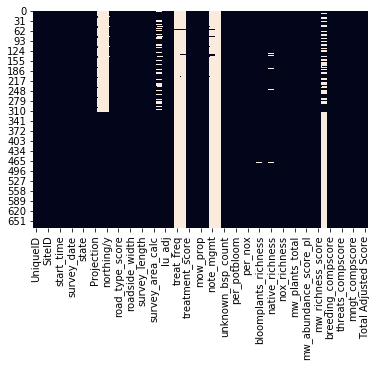

In [5]:
sns.heatmap(df.isnull(), cbar=False)

Since the plot size is a bit small, we'll use matplotlib to increase the plot size and let us see all of the columns along the x axis. Now we can see that the geometry data is missing from the first half of the dataset.

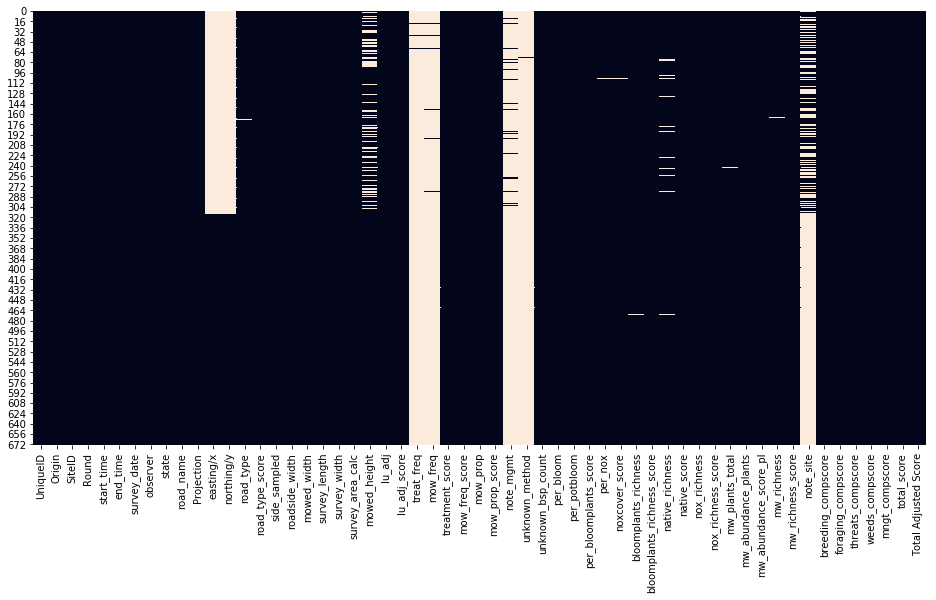

In [6]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(data=df.isnull(), ax=ax, cbar=False)

Let's figure out why there are so many nan values in the top half of this dataset for the easting and northing columns. First, we'll need to subset the dataframe where either the easting or northing is null. I'll then use value_counts to check out a few columns that might be explanatory, like state or observer, to see if there is a pattern when compared to the full dataset. After swapping in a few columns, I can tell that only the state of OK has non-null values for the easting and northing.

In [7]:
df[(df['easting/x'].isnull()) | (df['northing/y'].isnull())]['state'].value_counts()

MN    308
WI      4
IL      3
DE      1
Name: state, dtype: int64

In [8]:
df[(df['easting/x'].notnull()) | (df['northing/y'].notnull())]['state'].value_counts()

OK    358
Name: state, dtype: int64

To find where data is not numeric, we can use a heatmap again but this time pass in a lambda function to check the type of each observation. I've subsetted the dataframe to the state of OK and only those columns that I'm interested in (in this case, the geometry). We see one record in the 'northing/y' column that is non-numeric.

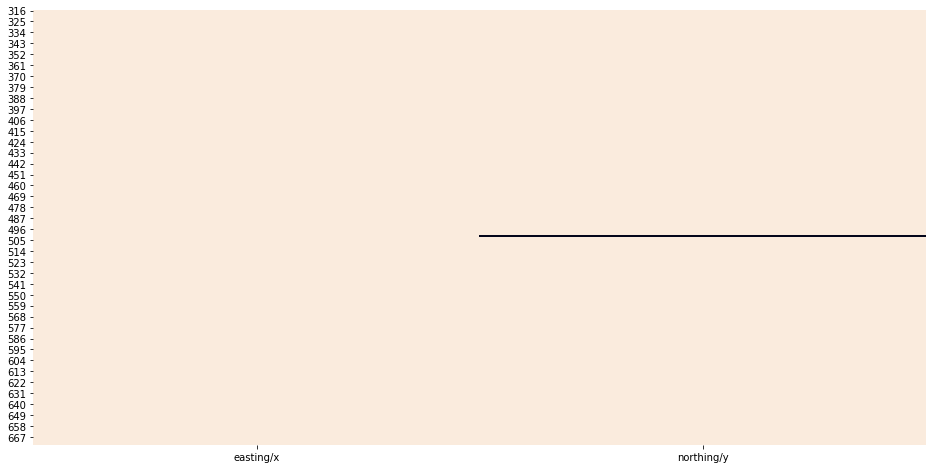

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(data=df[df['state']=='OK'].loc[:,'easting/x':'northing/y'].applymap(lambda x: isinstance(x, (int, float))), ax=ax, cbar=False)

To find the exact location of the non-numeric data, we could either (a) subset the dataframe or (b) ask for the specific record of the offending data. Both are illustrated below. Because working on one column is actually working on a Series, we'll use map instead of applymap.

In [10]:
df[df['northing/y'].map(lambda x: not isinstance(x, (float, int)))]

,UniqueID,Origin,SiteID,Round,start_time,end_time,survey_date,observer,state,road_name,...,mw_richness,mw_richness_score,note_site,breeding_compscore,foraging_compscore,threats_compscore,weeds_compscore,mngt_compscore,total_score,Total Adjusted Score
502,Y3-2-1,KB-OK,Y3-2,1,15:22:00,15:31:00,2018-06-06,"AK, EG",OK,HW81,...,0.0,0,NaN,0.0,8.4375,8.125,6.5625,3.0,26.125,30.377907


In [11]:
df[df['northing/y'].map(lambda x: not isinstance(x, (float, int)))]['northing/y']

502    NR
Name: northing/y, dtype: object

Lets check all of the data in this record by printing a transposed version of the record, which will be easier to review.

In [12]:
df[df['northing/y'].map(lambda x: not isinstance(x, (float, int)))].T

,502
UniqueID,Y3-2-1
Origin,KB-OK
SiteID,Y3-2
Round,1
start_time,15:22:00
end_time,15:31:00
survey_date,2018-06-06 00:00:00
observer,"AK, EG"
state,OK
road_name,HW81


Now, what to do with this record? It's not clear what 'NR' signifies. Probably best to just exclude it from any geographic analyses. It may be ok to include in analyses of other variables since everything else looks reasonable. If we had a better understanding of how these data were generated (FYI it was through Survey123) we might be able to fix this error or impute the data. Let's check the data around it to see if we can find a pattern. It's clear that 502 and 503 seem to go together (Site ID is Y3-2 and Y3-1, similar scores and other values). If we're ok with a bit of inaccuracy in the location, we could impute the value as the same northing as 503. 

In [13]:
df.iloc[500:505,:].T

,500,501,502,503,504
UniqueID,Y31-3-1,Y32-1,Y3-2-1,Y3-3-1,Y33-1-1
Origin,KB-OK,KB-OK,KB-OK,KB-OK,KB-OK
SiteID,Y31-3,Y32,Y3-2,Y3-3,Y33-1
Round,1,1,1,1,1
start_time,15:52:00,12:31:00,15:22:00,15:46:00,20:16:00
end_time,16:01:00,12:37:00,15:31:00,16:05:00,20:23:00
survey_date,2018-06-13 00:00:00,2018-05-29 00:00:00,2018-06-06 00:00:00,2018-06-06 00:00:00,2018-06-14 00:00:00
observer,"JK, EG","JK, EG","AK, EG","AK, EG","JK, EG"
state,OK,OK,OK,OK,OK
road_name,HW39,HW64,HW81,HW81,HW9


A quick way to visualize geographic point data like this is a scatterplot. We'll make lists of the geoghraphic data because that will run a bit faster, but you can plot a Series as well. We'll subset by state = OK to focus on just one state (and because we know there is no data for other states). We'll also plot without the missing value (which we know is 'NR').

In [14]:
x = list(df[(df['state']=='OK') & (df['northing/y'] != 'NR')]['easting/x'])

In [15]:
y = list(df[(df['state']=='OK') & (df['northing/y'] != 'NR')]['northing/y'])

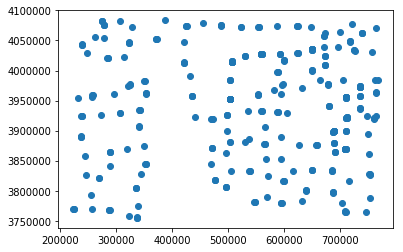

In [16]:
plt.scatter(x,y)

After fully exploring the data, we're ready to either (a) save out a cleaned up version or (2) write a script to clean up the data upon read in. We've discovered a couple things: (1) only the state of Oklahoma has geometry data and (2) one record in the 'northing/y' column has an incorrect value. I'll opt to save out a cleaned up version since I only want observations that have geometry so I'll be significantly subsetting the data.

First, let's subset the data to only Oklahoma. We'll make a copy so we're not working on a view of the original dataset.

In [17]:
df_ok = df[df['state']=='OK'].copy()

In [18]:
impute_value = df_ok.loc[503]['northing/y']
impute_value

3977830

In [19]:
df_ok['northing/y'].replace('NR', impute_value, inplace=True)

In [20]:
df_ok.to_excel(r'C:\Users\Erik\OneDrive - Environmental Incentives\Downloads\nchrp_data_2018_ok.xlsx')

In the next notebook, we'll build a quick dashboard to facilitate data exploration.